In [44]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sys import exit
from lxml import etree
from scipy import signal
from sklearn import preprocessing
from scipy import optimize
import regex as re
import timeit
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from lmfit.models import StepModel, LinearModel
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
from numpy import trapz
from sklearn.neighbors import LocalOutlierFactor
import h5py
import pickle
from sklearn.decomposition import PCA
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import find_peaks, peak_prominences
%matplotlib inline
import itertools
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import ipyparams

output_notebook()


Loading BokehJS ...

In [95]:
def Fold_Folders(mainpath):
    
    
    folder_path=mainpath+'\\'+'hdf5'
    
    metadatapath=mainpath+'\\'+'hdf5'
    
    save_to=mainpath+'\\'+'csv'
    
    
    if 'csv' not in os.listdir(mainpath):
        
        os.mkdir(save_to)
    
    
    
    dirs=os.listdir(mainpath)
    
    walk=list(os.walk(mainpath))
    
    walkpaths=[i for index in walk  for i in index if isinstance(i, str)==True]
    
    if 'hdf5' in dirs:
    
        folder_path=mainpath+'\\'+'hdf5'
        
    else:
        
        'Convert spikes and save in hdf5 folder'
        
    mwsdir=[i for i  in dirs if 'mws' in i ]
    
    
    if len(mwsdir)>0:
        
        metadatapath=mainpath
        
    elif len(walkpaths)>0:
        
        for wpth in walkpaths:
            
            dirswpth=os.listdir(wpth)
            
            mwsdirpth=[i for i  in dirswpth if 'mws' in i ]
            
            if len(mwsdirpth)>0:
                
                metadatapath=wpth
                
    else:
        print('no mwsin directory')
        
        
        
    return (folder_path, metadatapath, save_to)
 
    

Exception ignored in: <function RawData.__del__ at 0x0000024E1831FE50>
Traceback (most recent call last):
  File "C:\Users\MEA_PC\anaconda3\lib\site-packages\McsPy\McsData.py", line 68, in __del__
    if self.h5_file:
AttributeError: 'RawData' object has no attribute 'h5_file'


In [46]:
#Raw Load function
def load_raw(path, identifier, identifier2):

    dirs = os.listdir(path)
    
    print(dirs, 'dirs')


    filename=[]
    experiments={}


    for f in dirs:

        if (re.search('h5', f) and re.search(identifier, f) and (identifier2 in f)):

            filename.append(f)
            MetadataFilename=path+'/'+f[:-7]+'.mws'

            Recordingfile=path+'/'+f
            recording=McsPy.McsData.RawData(Recordingfile)

            tree = etree.parse(MetadataFilename)
            ExperimentID=tree.xpath('//ExperimentID/text()')[0]
            CompoundID=recording.comment
            if ExperimentID not in experiments.keys():

                experiments[ExperimentID]={CompoundID:[]}
            else:
                experiments[ExperimentID].update({CompoundID:[]})








    return filename, experiments

In [47]:
def led_info(Recordingfilename, Metadatafile):

    """Fuction to extract the LED stimulated well label, led color, led times and duration of the pulse"""

    R=McsPy.McsData.RawData(Recordingfilename)

    Info={}

    LED_T=[]
    LED_D=[]
    W=[]
    L=[]


    if len(list(R.recordings[0].event_streams.keys()))>3:



        for i in list(R.recordings[0].event_streams[3].event_entity.keys()):



            Wells=R.recordings[0].event_streams[3].event_entity[i].info.__dict__['info']['SourceChannelLabels']

            Label=R.recordings[0].event_streams[3].event_entity[i].info.__dict__['info']['Label']

            #print(R.recordings[0].event_streams[3].event_entity[i].info.__dict__['info']['EventID'], 'led')
            LED_T.append(R.recordings[0].event_streams[3].event_entity[i].data[0].tolist())
            LED_D.append(R.recordings[0].event_streams[3].event_entity[i].data[1].tolist())

            W.append(Wells)
            L.append(Label)



        Info['Wells']=W
        Info['Label']=L
        Info['Time']=LED_T
        Info['Duration']=LED_D


    return Info


In [48]:
def Dilutions(tree, Compound):
    r=tree.getroot()
    dilutions={}
    for compound in r[1][0][1].getchildren():
        Series=[]
        for ser in compound[0][-1][0][1].getchildren():
            Series.append(ser.attrib['Dilution'].split(" ")[0])

        dilutions[str(compound[0][1].text)]=Series

    Labels=dilutions[Compound]

    return Labels

In [49]:
def lab_book(tree):

    labbook={}

    root=tree.getroot()


    lablist=root[1][1].getchildren()

    for i in range(len(lablist)):


        labbook[root[1][1][i].tag]=root[1][1][i].text


    return labbook


In [50]:
#(spks_wavef, ((mins*50)+(start*50)), amplitudes, X[:, 0], lof, 
 #           np.concatenate((features, pca_features), axis=1), stdlist)

In [51]:
def sd_extension(mydict, i,  APs, ExperimentID, Welllabel, WellID, Channellabel, Compound, dose_label, es):

    size=len(APs[1])

    print(len(APs[1]),'times')

    print(len(APs[2]),'amplitude')

    print(len(APs[3]), 'duration')




    mydict['Timestamp [µs]'].extend(APs[1])
    mydict['Peak Amplitudes'].extend(APs[2])
    mydict['Duration'].extend(APs[3])
    mydict['Experiment'].extend(np.repeat(ExperimentID, size))
    mydict['Well Label'].extend(np.repeat(Welllabel[i], size))
    mydict['Well ID'].extend(np.repeat(WellID[i], size))
    mydict['Channel ID'].extend(np.repeat(i, size))
    mydict['Channel Label'].extend(np.repeat(Channellabel[i], size))
    mydict['Dose Label'].extend(np.repeat(dose_label, size))
    mydict['ES_condition'].extend(np.repeat(es, size))
    mydict['Compound ID'].extend(np.repeat(Compound, size))
    mydict['Threshold'].extend(np.repeat(APs[6][0], size))
    
    mydict['BaselineM'].extend(np.repeat(APs[6][1], size))
    
   
 
    return mydict


In [52]:
def AP_detection_lofnewest(to, lof, signal, partlength, dead_time, threshold, negative, positive,
                           fs, duration, learn, noisereduced, start=0):
    
    
    ##PAYTSARS SUGGESTION; SPLIT INTO MANY PARTS TAKE MIN OF DITRIBUTION
    split=int(len(signal)//(2*partlength))
    
    if split>0:
        
        parted_signal=np.array_split(signal, split)
        
        stds=[np.std(subsignal[:]) for subsignal in parted_signal]
    else:
        
        stds=[np.std(signal[:])]
        
    
    
    dead_time=(fs/1000)*dead_time

    duration=(fs/1000)*duration
    
    


    pretrig=(fs/1000)*1
    postrig=(fs/1000)*2

    ##maximum spike duration
    
    maxdur=duration*1.5
    


    ##thresholds
    #stds=[np.std(subsignal[:]) for subsignal in parted_signal]
    
    stdused=np.std(signal[:])
    
    minstd=min(stds)
    meanstd=np.mean(stds)
    
    medianstd=np.median(stds)
    
    stdlist=[minstd, medianstd]
    
    if positive==False:
        
        negpeak_idxs, pospeak_idxs=peaknew(signal, positive, negative)
        
        
        
        threshold_crossings_idx=np.where(signal <(-threshold*medianstd))[0]
        
        #print(negpeak_idxs, pospeak_idxs, threshold_crossings_idx)
        
        peak_idx=np.intersect1d(negpeak_idxs, threshold_crossings_idx)

    else:
        negpeak_idxs, pospeak_idxs=peaknew(signal, positive, negative)
        
        threshold_crossings_idx=np.where((signal>(threshold)*medianstd) | (signal<(-threshold)*medianstd))[0]
        
        #print(negpeak_idxs[:10], pospeak_idxs[:10], threshold_crossings_idx[:10])
        
        peak_idx=negpeak_idxs+pospeak_idxs
        
        
    
        peak_idx=np.intersect1d(peak_idx, threshold_crossings_idx)



    ###should not start with spike
    indexes=[i for i in range(len(peak_idx)) if (((peak_idx[i]-int(duration))>0) & ((peak_idx[i]+duration)<len(signal)))]
    mins=np.array(sorted(peak_idx[indexes]))
    
    
    """removing spikes that violate dead time criteria also 50us peaks"""

    while np.any(np.diff(mins)<dead_time):

        dead_idx=(np.where(np.diff(mins)<dead_time)[0]+1).tolist()
        mins=np.delete(mins, dead_idx)
        
        
    if noisereduced==True:
        
        noisikner=PipNoise_detection(signal, 0.5, 5, True, True, 20000, 3)[1]
        
        print(noisikner, 'noisikner', len(noisikner))
        
        
        if len(noisikner)>0:
            
            #print(noisikner, 'sectime')
            
        
            noisik=np.array([np.arange(n-500, n+500, 1) for n in noisikner]).ravel()
            
            #print(noisik, 'noisik')
            mins=np.array([m for m in mins if m not in noisik ])
            
            print(mins, 'after noisik ')
            
    if len(mins)>1:


        # for testing will be >=1 but for the data >1



        spks_wavef=np.array([signal[i-int(duration/2):i+int(duration/2)+1] for i in mins])
        
        print(spks_wavef.shape, duration, 'shapedur', len(mins))


        amplitudes=np.median(spks_wavef[:, :], axis=1)-spks_wavef[:, int(spks_wavef.shape[1]/2)]

        features=np.apply_along_axis(wvf_features, 1, spks_wavef)
        
        #amplitudes=np.apply_along_axis(peak_prominences, 1, spks_wavef, [int(spks_wavef.shape[1]/2)] )[:, 0]
        
        #print(amplitudes.shape, 'amplshape',  int(spks_wavef.shape[1]/2))
        
        pca_features=pca(spks_wavef, 4)
        
        X=np.concatenate((amplitudes.reshape(amplitudes.shape[0], 1), pca_features), axis=1)
        
        print(X.shape,  spks_wavef.shape, 'shapes')



        if len(mins)>500 and learn==True:
            lof.fit(X)
 
       

    else:
        X=np.empty([0, 5])
        mins=np.array([])
        spks_wavef=np.empty([0, int(duration+1)])
        amplitudes=np.array([])
        features=np.empty([0, 24])
        pca_features=np.empty([0, 4])
        stdlist=[[], []]
        
        
        
    

    fig, ax = plt.subplots()
    ax.plot(signal)
    
    if len(mins)>0:


        y = np.interp(mins, np.arange(0, len(signal), 1), signal)
        ax.plot(mins, y, ls="", marker="*", ms=15,  color="crimson", alpha=0.3)
        plt.axhline(y=(-threshold*medianstd))
        plt.axhline(y=(threshold*medianstd))
    #plt.savefig(to+'/'+str(len(mins))+'Spikes'+'.tif', format='tif')
    plt.show()



    #print(features.shape,'rfshape' )

    #print(pca_features.shape,'pcarfshape' )
    
    
    #print(spks_wavef.shape, len(((mins*50)+(start*50))),  len(amplitudes), np.concatenate((features, pca_features), axis=1).shape)
    #print(mins, 'minslater')
    
    
    
        



    return (spks_wavef, ((mins*50)+(start*50)), amplitudes, X[:, 0], lof, 
            np.concatenate((features, pca_features), axis=1), stdlist)

In [53]:
def peak(cut, positive, negative):

    sign_diff=np.diff(np.sign(np.diff(cut)))
    
    
    
    
    
    


    ###print(cut,  np.diff(cut),  np.sign(np.diff(cut)), sign_diff, 'signdiffpeak')

    peak_idx=[]


    if negative==True:

        peak_indices=(np.where(sign_diff==2)[0]+1).tolist()
        if len(peak_indices)>0:
            #all negative peaks  peaks
            pk=np.argmin(cut[peak_indices])
            peak_idx=[peak_indices[pk]]

    if (positive==True) and (len(peak_idx)==0):

        peak_indices=(np.where(sign_diff==-2)[0]+1).tolist()
        if len(peak_indices)>0:
            #all negative peaks  peaks
            pk=np.argmax(cut[peak_indices])
            peak_idx=[peak_indices[pk]]

        #maximum negative peak actual index
    #np.where((sign_diff==2)|(sign_diff==-2))[0].tolist()
    #So, really it would be nice to have both positive and negative peaks' cutouts and find AP via negative peak.


    return (peak_idx, peak_indices)

In [54]:
def peaknew(cut, positive, negative):

    sign_diff=np.diff(np.sign(np.diff(cut)))
    

    ###print(cut,  np.diff(cut),  np.sign(np.diff(cut)), sign_diff, 'signdiffpeak')

    positive_index=[]
    
    
    negative_index=[]


    if negative==True:

        negative_index=(np.where(sign_diff==2)[0]+1).tolist()
       

    if (positive==True):

        positive_index=(np.where(sign_diff==-2)[0]+1).tolist()
        #maximum negative peak actual index
    #np.where((sign_diff==2)|(sign_diff==-2))[0].tolist()
    #So, really it would be nice to have both positive and negative peaks' cutouts and find AP via negative peak.


    return (negative_index, positive_index)

In [55]:
def peakslope(cut, positive, negative):

    sign_diff=np.diff(np.sign(np.diff(cut)))
    

    ###print(cut,  np.diff(cut),  np.sign(np.diff(cut)), sign_diff, 'signdiffpeak')

    positive_index=[]
    
    
    negative_index=[]


    if negative==True:

        negative_index=(np.where(sign_diff==2)[0]+1).tolist()
       

    if (positive==True):

        positive_index=(np.where(sign_diff==-2)[0]+1).tolist()
        #maximum negative peak actual index
    #np.where((sign_diff==2)|(sign_diff==-2))[0].tolist()
    #So, really it would be nice to have both positive and negative peaks' cutouts and find AP via negative peak.


    return (negative_index, positive_index)

In [56]:
def wvf_features(wvf):

    features=np.zeros(24)

    #shape


    FD=np.diff(wvf)
    sign_diff=np.diff(np.sign(FD))
    zero_cross=(np.where((sign_diff==-2)|(sign_diff==2))[0])
    #zer_cross=(np.where((sign_diff==2))[0]+1)
    ##print('zero cross', zer_cross)

    AP_peak_cross=int(len(wvf)//2)-1 #AP peak index in FD (zero_crossing)


    try:
        peaks=np.where(np.diff(np.sign(np.diff(FD)))==-2)[0]+1
    except:
        peaks=np.array([])
    try:
        valleys=np.where(np.diff(np.sign(np.diff(FD)))==2)[0]+1
    except:
        valleys=np.array([])
    try:
        p1=np.sort(peaks[(peaks-AP_peak_cross)<0])[-1]
    except:
        p1=0
    try:
        p2=np.argmin(FD)
    except:
        p2=0
    ### valley of FD
    try:
        p3=AP_peak_cross
    except:
        p3=0
        ## second zero crossing (crossing )
    try:
        p4=np.sort(peaks[(peaks-AP_peak_cross)>0])[0]
    except:
        p4=0
    try:#np.argmax(FD) #peak of PD
        p5=np.sort(zero_cross[(zero_cross-AP_peak_cross)>0])[0]
    except:
        p5=0#zero_crossing after AP_zero_cross
    try:
        p6=np.sort(valleys[(valleys-AP_peak_cross)>0])[0]
    except:
        p6=0#valley after zero cross


    #fig, ax = plt.subplots()
    #ax.plot(FD)

    #y = np.interp([p1, p2, p3, p4, p5, p6], np.arange(0, len(FD), 1), FD)
    #ax.plot([p1, p2, p3, p4, p5, p6], y, ls="", marker="*", ms=15,  color="crimson")
    #plt.title('Feature guides')
    #plt.show()



    try:
        features[0]=p5-p1
    except:
        features[0]=0

    try:
        features[1]= FD[p4]-FD[p2]
    except:

        features[1]=0

    try:
        features[2]=FD[p6]-FD[p2]  #F3 correlation with reference waveform is missing
    except:
        features[2]=0

    try:
        features[3]=np.log(np.abs((FD[p4]-FD[p2])/(p4-p2)))

    except:
        features[3]=0

    try:
        features[4]=(FD[p6]-FD[p4])/(p6-p4)

    except:
        features[4]=0

    try:
        features[5]=np.log(np.abs((FD[p6]-FD[p2])/(p6-p2)))

    except:
        features[5]=0

    try:
        features[6]=np.sqrt(np.abs(np.mean(FD[:p2]))) #root mean square of pre-event amplitudes (added np/abs to avoid neg.)

    except:
        features[6]=0
    try:
        features[7]=((FD[p2]-FD[p1])/(p2-p1))/((FD[p3]-FD[p2])/(p3-p2))

    except:
        features[7]=0

    try:
        features[8]=((FD[p4]-FD[p3])/(p4-p3))/((FD[p5]-FD[p4])/(p5-p4))

    except:
        features[8]=0

    try:
        features[9]=FD[p2]/FD[p4]

    except:
        features[9]=0

    #phase based features

    features[10:16]=FD[[p1, p2, p3, p4, p5, p6]]
    try:
        features[16:19]=np.diff(FD)[[p1-1, p3-1, p5-1]] #second derivative of  zeros_crossings
    except:
        features[16:19]=0


    #distribution based features

    features[19]=np.percentile(FD, 75)-np.percentile(FD, 25)
    features[20]=np.percentile(np.diff(FD), 75)-np.percentile(np.diff(FD), 25)
    features[21]=skew(FD)
    features[22]=skew(np.diff(FD))
    features[23]=kurtosis(FD)




    return features



In [57]:
def pca(wvfs, comps):

    if wvfs.shape[0]>10:


        pca=PCA(n_components=comps)
        wvfs_pca=pca.fit_transform(wvfs)
    else:
        wvfs_pca=np.zeros([wvfs.shape[0], 4])



    return wvfs_pca


In [58]:
#Clusterization








In [59]:
def AP_cutouts(v, dead_time, threshold, negative, positive, fs, duration, start=0):

    """The spike detection function, which takes channel
    raw data as an input and outputs spike parameters, here the spike cutout also beign extracted, amplitude is absolute"""


    dv=np.diff(v)#the derivative of the signal

    sign_diff=np.diff(np.sign(dv)) #the difference of the signs of derivative

     #parameter to  filter spikes by duration

    dead_time=(dead_time*fs)/1000  #parameter for refractory period consideration


    if negative==False:  #detect positive peaks


        peak_idx=(np.where(sign_diff==(-2))[0]+1).tolist() # idx where the sign difference is -2, idx+1 is peak
        threshold_crossings_idx=np.where(v>(threshold)*np.std(v[:]))[0] #threshold filtering, via std of 1s of data
        AP_idx=np.intersect1d(peak_idx, threshold_crossings_idx)# intersect peaks and thresholds

    if positive==False:   #detect negative peaks

        peak_idx=(np.where(sign_diff==(2))[0]+1).tolist()#
        threshold_crossings_idx=np.where(v<(-threshold)*np.std(v[:]))[0]
        AP_idx=np.intersect1d(peak_idx, threshold_crossings_idx)

    if (positive==True) and (negative==True): #detect both, positive and negative peaks

        peak_idx=(np.where((sign_diff==(-2)) | (sign_diff==(2)))[0]+1).tolist()

        threshold_crossings_idx=np.where((v>(threshold)*np.std(v[:])) | (v<(-threshold)*np.std(v[:])))[0]

        AP_idx=np.intersect1d(peak_idx, threshold_crossings_idx)

        dead_idx=(np.where(np.diff(AP_idx)<dead_time)[0]+1).tolist()
        AP_idx=np.delete(AP_idx, dead_idx)

    while np.any(np.diff(AP_idx)<dead_time):

        dead_idx=(np.where(np.diff(AP_idx)<dead_time)[0]+1).tolist()
        AP_idx=np.delete(AP_idx, dead_idx)



    spks_wavef=np.array([v[i-int(duration/2):i+int(duration/2)] for i in AP_idx])

    features=np.apply_along_axis(wvf_features, 1, spks_wavef)
    pca_features=pca(spks_wavef, 4)

    fig, ax = plt.subplots()
    ax.plot(signal)


    y = np.interp(AP_idx, np.arange(0, len(v), 1), v)
    ax.plot(AP_idx, y, ls="", marker="*", ms=15,  color="crimson")
    plt.axhline(y=(-threshold*np.std(v[:])))
    plt.savefig(to+'/'+str(len(AP_idx))+'Spikes'+'.tif', format='tif')
    plt.show()

    return (AP_idx[1:], ((np.array(AP_idx)*50)+(start*50))[1:].tolist(),  features[1:, :], pca_features[1:, :])

In [60]:
def thresholdsplot(signal, threshold):
    
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(stds)
    plt.hlines(y=stdused, xmin=0, xmax=180, colors='red', label='Before')
    plt.hlines(y=meanstd, xmin=0, xmax=180, colors='black', label='Mean', linestyles='dotted')
    plt.hlines(y=minstd, xmin=0, xmax=180, colors='green', label='Min')
    plt.hlines(y=medianstd, xmin=0, xmax=180, colors='yellow', label='Median')
    
    plt.legend()
    
    plt.title('stdsvalues')
   
    plt.show()

In [61]:
def AP_detection_lofnew(to, lof, signal, dead_time, threshold, negative, positive, fs, duration, learn, start=0):
    
    
    ##PAYTSARS SUGGESTION; SPLIT INTO MANY PARTS TAKE MIN OF DITRIBUTION
    split=int(len(signal)//(2*20000))
    parted_signal=np.array_split(signal, split)
    
    
    dead_time=(fs/1000)*dead_time

    duration=(fs/1000)*duration
    
    


    pretrig=(fs/1000)*1
    postrig=(fs/1000)*2

    ##maximum spike duration
    
    maxdur=duration*1.5
    


    ##thresholds
    stds= [np.std(subsignal[:]) for subsignal in parted_signal]
    
    stdused=np.std(signal[:])
    
    minstd=min(stds)
    meanstd=np.mean(stds)
    
    medianstd=np.median(stds)
    
    stdlist=[minstd, medianstd]
    
    if positive==False:
        
        negpeak_idxs, pospeak_idxs=peaknew(signal, positive, negative)
        
        
        
        threshold_crossings_idx=np.where(signal <(-threshold*medianstd))[0]
        
        #print(negpeak_idxs, pospeak_idxs, threshold_crossings_idx)
        
        peak_idx=np.intersect1d(negpeak_idxs, threshold_crossings_idx)

    else:
        negpeak_idxs, pospeak_idxs=peaknew(signal, positive, negative)
        
        threshold_crossings_idx=np.where((signal>(threshold)*medianstd) | (signal<(-threshold)*medianstd))[0]
        
        #print(negpeak_idxs[:10], pospeak_idxs[:10], threshold_crossings_idx[:10])
        
        peak_idx=negpeak_idxs+pospeak_idxs
        
        
    
        peak_idx=np.intersect1d(peak_idx, threshold_crossings_idx)



    ###should not start with spike
    indexes=[i for i in range(len(peak_idx)) if (((peak_idx[i]-int(duration))>0) & ((peak_idx[i]+duration)<len(signal)))]
    mins=np.array(sorted(peak_idx[indexes]))
    
    
    """removing spikes that violate dead time criteria also 50us peaks"""

    while np.any(np.diff(mins)<dead_time):

        dead_idx=(np.where(np.diff(mins)<dead_time)[0]+1).tolist()
        mins=np.delete(mins, dead_idx)
   

   
    if len(mins)>1:


        # for testing will be >=1 but for the data >1



        spks_wavef=np.array([signal[i-int(duration/2):i+int(duration/2)+1] for i in mins])
        
        print(spks_wavef.shape, duration, 'shapedur', len(mins))


        amplitudes=np.median(spks_wavef[:, :], axis=1)-spks_wavef[:, int(spks_wavef.shape[1]/2)]

        features=np.apply_along_axis(wvf_features, 1, spks_wavef)
        
        #amplitudes=np.apply_along_axis(peak_prominences, 1, spks_wavef, [int(spks_wavef.shape[1]/2)] )[:, 0]
        
        #print(amplitudes.shape, 'amplshape',  int(spks_wavef.shape[1]/2))
        
        pca_features=pca(spks_wavef, 4)
        
        X=np.concatenate((amplitudes.reshape(amplitudes.shape[0], 1), pca_features), axis=1)
        
        print(X.shape,  spks_wavef.shape, 'shapes')



        if len(mins)>500 and learn==True:
            lof.fit(X)
 
       

    else:
        X=np.empty([0, 5])
        mins=np.array([])
        spks_wavef=np.empty([0, int(duration+1)])
        amplitudes=np.array([])
        features=np.empty([0, 24])
        pca_features=np.empty([0, 4])
        stdlist=[[], []]

    fig, ax = plt.subplots()
    ax.plot(signal)


    y = np.interp(mins, np.arange(0, len(signal), 1), signal)
    ax.plot(mins, y, ls="", marker="*", ms=15,  color="crimson", alpha=0.3)
    plt.axhline(y=(-threshold*medianstd))
    plt.axhline(y=(threshold*medianstd))
    #plt.savefig(to+'/'+str(len(mins))+'Spikes'+'.tif', format='tif')
    plt.show()



    #print(features.shape,'rfshape' )

    #print(pca_features.shape,'pcarfshape' )
    
    
    print(spks_wavef.shape, len(((mins*50)+(start*50))),  len(amplitudes), np.concatenate((features, pca_features), axis=1).shape)




    return (spks_wavef, ((mins*50)+(start*50)), amplitudes, X[:, 0], lof, 
            np.concatenate((features, pca_features), axis=1), stdlist)

In [62]:
def AP_detection_lof(to, lof, signal, dead_time, threshold, negative, positive, fs, duration, learn, start=0):

    if positive==False:
        r1=(signal <=(-threshold*np.std(signal[10000:]))).astype('int64')

    else:
         r1=((signal <=(-threshold*np.std(signal[:]))) | (signal >=(threshold*np.std(signal[:])))).astype('int64')


    dead_time=(fs/1000)*dead_time

    duration=(fs/1000)*duration

    buffer=20 #1ms to detect aps with positive threshold crossings but not negative
    
    
    r1=r1[np.where(r1==0)[0][0]:]





    diffr1=np.diff(r1)
    ###print(r1[:5000])
    rights=np.where(diffr1==(-1))[0]+1
    lefts=np.where(diffr1==1)[0]

    #ranges=np.where(diffr1==(-1))[0]-np.where(diffr1==1)[0]
    lefts=lefts[:len(rights)]
    rights=rights[:len(lefts)] #


    #in range min index + left original index

    #dead time_sufficient
    dead_idx=(np.where(np.diff(lefts)<dead_time)[0]+1).tolist()
    lefts=np.delete(lefts, dead_idx)
    rights=np.delete(rights, dead_idx)
    ###print(len(lefts))

    """removing spikes that violate dead time criteria also 50us peaks"""

    while np.any(np.diff(lefts)<dead_time) or np.any((rights-lefts)<1) or np.any((rights-lefts)>60):

        dead_idx=(np.where(np.diff(lefts)<dead_time)[0]+1).tolist()
        lefts=np.delete(lefts, dead_idx)
        rights=np.delete(rights, dead_idx)
    #no data
        to_delmin=np.where((rights-lefts)<1)[0].tolist()
        lefts=np.delete(lefts, to_delmin)
        rights=np.delete(rights, to_delmin)

        to_delmax=np.where((rights-lefts)>60)[0].tolist()
        lefts=np.delete(lefts, to_delmax)
        rights=np.delete(rights, to_delmax)

    #try:

    ##print(lefts, 'lefts')
    ##print(rights, 'rights')

    mins=np.array([peak(signal[(lefts[i]):(rights[i]+1)], positive, negative)[0][0]+(lefts[i]) for i in range(len(lefts))
                   if len(peak(signal[(lefts[i]):(rights[i]+1)], positive, negative)[0])>0]) #future peak search
    ind=[i for i in range(len(lefts)) if len(peak(signal[lefts[i]:(rights[i]+1)], positive, negative)[0])>0]
    lefts=lefts[ind]
    rights=rights[ind]#future peak search

    indexes=[i for i in range(len(mins)) if (((mins[i]-int(duration/2))>0) & ((mins[i]+int(duration/2))<len(signal)))]
    mins=mins[indexes]
    lefts=lefts[indexes]
    rights=rights[indexes]



    #except:
        #ValueError



        #mins=[]


    if len(mins)>1:

        divide=(mins-lefts)
        divide[divide==0]=1
        rise_vel=(np.abs(signal[mins]-signal[lefts]))/divide





        divide=(rights-mins)
        divide[divide==0]=1
        fall_vel=(np.abs(signal[rights]-signal[mins]))/divide

        # for testing will be >=1 but for the data >1



        spks_wavef=np.array([signal[i-int(duration/2):i+int(duration/2)] for i in mins])


        amplitudes=spks_wavef[:, 0]-spks_wavef[:, int(spks_wavef.shape[1]/2)]

        features=np.apply_along_axis(wvf_features, 1, spks_wavef)



        pca_features=pca(spks_wavef, 4)



        X=np.concatenate((rise_vel.reshape(rise_vel.shape[0], 1), fall_vel.reshape(rise_vel.shape[0], 1),
                          amplitudes.reshape(amplitudes.shape[0], 1)), axis=1)
        #strange_index=np.where(fall_vel>10)[0].tolist()
        #strange=mins[strange_index]
        ###print(mins)



        if len(mins)>500 and learn==True:
            lof.fit(X)
  #u  outliers
        ###print(mins)

        if len(mins)>0:

            plt.figure()
            plt.xlabel('rise_vel')
            plt.ylabel('Fall_vel')
            plt.scatter(rise_vel, fall_vel)
            plt.scatter(X[:, 0], X[:, 1], color='yellow', alpha=0.2)
            plt.show()


    else:
        X=np.empty([0, 2])
        mins=np.array([])
        spks_wavef=np.empty([0, 60])
        amplitudes=np.array([])
        features=np.empty([0, 24])
        pca_features=np.empty([0, 4])

    fig, ax = plt.subplots()
    ax.plot(signal)


    y = np.interp(mins, np.arange(0, len(signal), 1), signal)
    ax.plot(mins, y, ls="", marker="*", ms=15,  color="crimson")
    plt.axhline(y=(-threshold*np.std(signal[:])))
    #plt.savefig(to+'/'+str(len(mins))+'Spikes'+'.tif', format='tif')
    plt.show()


    #plt.figure()
    #plt.plot(spks_wavef[0, :])
    #plt.show()

    #plt.figure()
    #plt.hist(rise_vel, bins='auto')
    #plt.show()

    #plt.figure()
    #plt.xlabel('rise_vel')
    #plt.ylabel('Fall_vel')
    #plt.scatter(rise_vel, fall_vel)
    #plt.scatter(X[:, 0], X[:, 1], color='yellow', alpha=0.2)

    #plt.savefig(to+'/'+str(len(mins))+'Features'+'.tif', format='tif')

    #only returns rise_vel but fall _vell is also important
    #Future spike wvf feature extraction , classification
    ##print(features.shape,'rfshape' )

    ##print(pca_features.shape,'pcarfshape' )




    return (spks_wavef, ((mins*50)+(start*50)), amplitudes, X[:, 0], lof, np.concatenate((features, pca_features), axis=1), threshold*np.std(signal[:]))

In [63]:
def AP_detection_lofNoise(signal, baseline, dead_time, threshold, negative, positive, fs, duration, start=0):

    if positive==False:
        r1=(signal <=(-threshold*np.std(signal[:]))).astype('int64')

    else:
         r1=((signal <=(-threshold*np.std(signal[:]))) | (signal >=(threshold*np.std(signal[:])))).astype('int64')


    dead_time=(fs/1000)*dead_time

    duration=(fs/1000)*duration

    pretrig=(fs/1000)*1
    postrig=(fs/1000)*2

    buffer=20 #1ms to detect aps with positive threshold crossings but not negative

    r1=r1[np.where(r1==0)[0][0]:]




    diffr1=np.diff(r1)

    ###pretrig is 2 data points, so there could be -1 or -2 at the the start of the trace if so replace with 0


    rights=(np.where(diffr1==(1))[0]+postrig).astype('int')
    lefts=(np.where(diffr1==1)[0]-pretrig).astype('int')

    lefts[(np.where(lefts)<0)[0]]=0



    ###

    true_rights=np.where(diffr1==(-1))[0]+1
    true_lefts=np.where(diffr1==1)[0]


    #ranges=np.where(diffr1==(-1))[0]-np.where(diffr1==1)[0]
    lefts=lefts[:len(rights)]
    rights=rights[:len(lefts)] #
    #print(lefts, rights, 'before')

    true_lefts=true_lefts[:len(true_rights)]
    true_rights=true_rights[:len(true_lefts)]

    #in range min index + left original index

    #dead time_sufficient
    dead_idx=(np.where(np.diff(lefts)<dead_time)[0]+1).tolist()

    dead_idx=(np.where(np.diff(true_lefts)<dead_time)[0]+1).tolist()

    #print(dead_idx)
    lefts=np.delete(lefts, dead_idx)
    rights=np.delete(rights, dead_idx)

    true_lefts=np.delete(true_lefts, dead_idx)
    true_rights=np.delete(true_rights, dead_idx)

    #print(lefts, rights, dead_time, rights-lefts, 'deadidx')
    ##print(len(lefts))

    """removing spikes that violate dead time criteria also 50us peaks"""

    while np.any(np.diff(lefts)<dead_time) or np.any((rights-lefts)<1) or np.any((rights-lefts)>maxdur):

        dead_idx=(np.where(np.diff(lefts)<dead_time)[0]+1).tolist()
        lefts=np.delete(lefts, dead_idx)
        rights=np.delete(rights, dead_idx)
    #no data
        to_delmin=np.where((rights-lefts)<1)[0].tolist()

        #print(to_delmin, 'delmin')
        lefts=np.delete(lefts, to_delmin)
        rights=np.delete(rights, to_delmin)

        to_delmax=np.where((rights-lefts)>maxdur)[0].tolist()

        #print(to_delmax, 'delmax')
        lefts=np.delete(lefts, to_delmax)
        rights=np.delete(rights, to_delmax)

    #try:

    #print(lefts, 'lefts', 'after')
    #print(rights, 'rights')

    mins=np.array([peak(signal[(lefts[i]):(rights[i])], positive, negative)[0][0]+(lefts[i]) for i in range(len(lefts))
                   if len(peak(signal[(lefts[i]):(rights[i])], positive, negative)[0])>0]) #future peak search
    ind=[i for i in range(len(lefts)) if len(peak(signal[lefts[i]:(rights[i]+1)], positive, negative)[0])>0]
    lefts=lefts[ind]
    rights=rights[ind]#future peak search


    #print(mins, 'mins')
    indexes=[i for i in range(len(mins)) if (((mins[i]-int(duration//2))>0) & ((mins[i]+int(duration//2))<len(signal)))]

    #print(mins, 'mins')


    mins=mins[indexes]
    lefts=lefts[indexes]
    rights=rights[indexes]



    #except:
        #ValueError



        #mins=[]


    if len(mins)>1:

        divide=(mins-true_lefts)
        divide[divide==0]=1
        rise_vel=(np.abs(signal[mins]-signal[true_lefts]))/divide





        divide=(true_rights-mins)
        divide[divide==0]=1
        fall_vel=(np.abs(signal[true_rights]-signal[mins]))/divide

        # for testing will be >=1 but for the data >1



        spks_wavef=np.array([signal[i-int(duration/2):i+int(duration/2)] for i in mins])


        amplitudes=spks_wavef[:, 0]-spks_wavef[:, int(spks_wavef.shape[1]/2)]

        features=np.apply_along_axis(wvf_features, 1, spks_wavef)



        pca_features=pca(spks_wavef, 4)



        X=np.concatenate((rise_vel.reshape(rise_vel.shape[0], 1), fall_vel.reshape(rise_vel.shape[0], 1),
                          amplitudes.reshape(amplitudes.shape[0], 1)), axis=1)


        lof = load_model('Novelty.pkl')
        yhat = lof.predict(X)



        ##find novel peaks indexes

        #mask = yhat != -1






        #X=X[mask, :]
        #spks_wavef=spks_wavef[mask, :]
        #amplitudes=amplitudes[mask]
        ##print(mins, '3rd')



        #mins=mins[mask]

        #print(mins)







  #u  outliers
        ##print(mins)

        if len(mins)>0:

            plt.figure()
            plt.xlabel('rise_vel')
            plt.ylabel('Fall_vel')
            plt.scatter(rise_vel, fall_vel)
            plt.scatter(X[:, 0], X[:, 1], color='yellow', alpha=0.2)
            plt.show()


    else:
        X=np.empty([0, 2])
        mins=np.array([])
        spks_wavef=np.empty([0, 60])
        amplitudes=np.array([])
        features=np.empty([0, 24])
        pca_features=np.empty([0, 4])

    fig, ax = plt.subplots()
    ax.plot(signal)


    y = np.interp(mins, np.arange(0, len(signal), 1), signal)
    ax.plot(mins, y, ls="", marker="*", ms=15,  color="crimson")
    plt.axhline(y=(-threshold*np.std(signal[:])))
    #plt.savefig(to+'/'+str(len(mins))+'Spikes'+'.tif', format='tif')

    #plt.xlim([19950, 20050])
    plt.show()




   

In [64]:
def PipNoise_detection(signal, dead_time, threshold, negative, positive, fs, duration):

    if positive==False:
        r1=(signal <=(-threshold*np.std(signal[:]))).astype('int64')

    else:
         r1=((signal <=(-threshold*np.std(signal[:]))) | (signal >=(threshold*np.std(signal[:])))).astype('int64')


    dead_time=(fs/1000)*dead_time

    duration=(fs/1000)*duration

    buffer=20 #1ms to detect aps with positive threshold crossings but not negative




    diffr1=np.diff(r1)
    ##print(r1[:5000])
    rights=np.where(diffr1==(-1))[0]+1
    lefts=np.where(diffr1==1)[0]

    #ranges=np.where(diffr1==(-1))[0]-np.where(diffr1==1)[0]
    lefts=lefts[:len(rights)]
    rights=rights[:len(lefts)] #


    #in range min index + left original index

    #dead time_sufficient
    dead_idx=(np.where(np.diff(lefts)<dead_time)[0]+1).tolist()
    lefts=np.delete(lefts, dead_idx)
    rights=np.delete(rights, dead_idx)
    ##print(len(lefts))

    """removing spikes that violate dead time criteria also 50us peaks"""

    #try:

    #print(lefts, 'lefts')
    #print(rights, 'rights')

    mins=np.array([peak(signal[(lefts[i]):(rights[i]+1)], positive, negative)[0][0]+(lefts[i]) for i in range(len(lefts))
                   if len(peak(signal[(lefts[i]):(rights[i]+1)], positive, negative)[0])>0]) #future peak search
    ind=[i for i in range(len(lefts)) if len(peak(signal[lefts[i]:(rights[i]+1)], positive, negative)[0])>0]
    lefts=lefts[ind]
    rights=rights[ind]#future peak search

    indexes=[i for i in range(len(mins)) if (((mins[i]-int(duration/2))>0) & ((mins[i]+int(duration/2))<len(signal)))]
    mins=mins[indexes]
    lefts=lefts[indexes]
    rights=rights[indexes]



    if len(mins)>1:

        divide=(mins-lefts)
        divide[divide==0]=1
        rise_vel=(np.abs(signal[mins]-signal[lefts]))/divide





        divide=(rights-mins)
        divide[divide==0]=1
        fall_vel=(np.abs(signal[rights]-signal[mins]))/divide

        # for testing will be >=1 but for the data >1
        
        spks_wavef=np.array([signal[i-int(duration/2):i+int(duration/2)] for i in mins])
        amplitudes=spks_wavef[:, 0]-spks_wavef[:, int(spks_wavef.shape[1]/2)]



        X=np.concatenate((rise_vel.reshape(rise_vel.shape[0], 1), fall_vel.reshape(rise_vel.shape[0], 1),
                              amplitudes.reshape(amplitudes.shape[0], 1)), axis=1)
        
        
        
        lof = load_model('Novelty.pkl')
        yhat = lof.predict(X)



        ##find novel peaks indexes
        masknoise = yhat == -1

        minsnoise=mins[masknoise]
        
        
        if len(minsnoise)>0:



            
            spks_wav=np.array([signal[i-int(duration/2):i+int(duration/2)] for i in minsnoise])
            amplitudes=spks_wav[:, 0]-spks_wav[:, int(spks_wav.shape[1]/2)]
            
        else:
            X=np.empty([0, 2])
            mins=np.array([])
            spks_wav=np.empty([0, 60])
            amplitudes=np.array([])
            features=np.empty([0, 24])
            pca_features=np.empty([0, 4])

            minsnoise=np.array([])



       

    else:
        X=np.empty([0, 2])
        mins=np.array([])
        spks_wav=np.empty([0, 60])
        amplitudes=np.array([])
        features=np.empty([0, 24])
        pca_features=np.empty([0, 4])

        minsnoise=np.array([])

    fig, ax = plt.subplots()
    ax.plot(signal, color='blue')

    if len(mins)>0:
 
        if len(minsnoise)>0:


            y = np.interp(minsnoise, np.arange(0, len(signal), 1), signal)
            ax.plot(minsnoise, y, ls="", marker="*", ms=15,  color="crimson")
            plt.axhline(y=(-threshold*np.std(signal[:])))
            plt.title('PIpnoiseplot')
            #plt.savefig(to+'/'+str(len(mins))+'Spikes'+'.tif', format='tif')
            plt.show()





    return (spks_wav, minsnoise, amplitudes, X, threshold*np.std(signal[:]))

In [65]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [66]:
def highpass(v, cutoff, order, fs):

    nyq = 0.5 * 20000

    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)

    filtered = signal.filtfilt(b, a, v)

    return filtered

In [67]:
def step_fit(t, response):
    step_mod=StepModel(form='linear', prefix='step_', nan_policy='omit') #step function
    #index=np.where(np.array(response)==np.array(response.min()))[0][0] #we dont need this
    ##print(index)
    scale=response.std()/response.mean()
    pars = step_mod.make_params(step_center=t.mean(),
                         step_amplitude=response.std(),
                         step_sigma=np.abs(scale)*1.5)  # parameters for the step function sigma=1.4 best parameter
    out = step_mod.fit(response, pars, x=t)

    return out.best_fit


def salpa(t, *p):
    return p[0]+(p[1])*(t)+(p[2])*((t)**2)+(p[3])*((t)**3)  #curve function


def salpa_fit(v, centroid):

    plt.figure()
    plt.plot(v)
    plt.title('Raw')
    plt.show()


    d=len(v)-(centroid)  #get upper range of

    t=np.arange(-int(centroid/2), int(centroid/2)).astype('int64')
    #print(t.shape)#centered on zero

    response=v[:len(t)]
    #print(response.shape)#

    y=step_fit(t, response).tolist()

    nc=np.arange(int(centroid), d).astype('int64') #get centroids


    for n in nc:

        t=np.arange(-int(centroid), int(centroid)).astype('int64') #arange input from -centroid to centroid, around zero

        response=v[int(n-centroid):int(n+centroid)]  #get signal window



        params, params_covariance = optimize.curve_fit(salpa, t, response, p0=np.ones(4))
        #optimize the function

        y_nc=salpa(t, *params)  #predict the central point value

        y.append(y_nc[int(centroid)]) #append only central point to list


    dv=np.array(v[: len(y)])-np.array(y)

    plt.figure()
    plt.plot(dv)
    plt.show()


    return dv

In [68]:
def Dose(event_entities):

    starts=[]
    stops=[]

    #print(event_entities.keys())

    for e in list(event_entities.keys()):
        ##print('key', e)


        label_info=event_entities[e].info.__dict__['info']['Label']
        ##print('label', label_info)

        time=event_entities[e].data[0]

        ##print('time', time)




        if re.search('ControlStart', label_info) or re.search('TestStart', label_info):
            starts.extend(time)

        if re.search('ControlStop', label_info) or re.search('TestStop', label_info):
            stops.extend(time)

    return starts, stops

In [69]:
def RArtifact(v, centroid, cutoff, order, fs, alg='StepSalpa'):

    #p = figure(title="Electrical Noise", x_axis_label='x', y_axis_label='y')



    if alg=='StepSalpa':


        dv=salpa_fit(v, centroid)

    else:


        dv=highpass(v, cutoff, order, fs)

    #p.line(np.arange(0, len(v), 1), v, legend_label="noise", line_width=2, color='red')
    #p.line(np.arange(0, len(dv), 1), dv, legend_label="Salpa", line_width=2, color='blue')
    #show(p)
    return dv

In [70]:
def SpikeDetection_EStim(to, lof, Recordingfilename, MetadataFilename, MetadataMaskPath, experiments, Analyze,
                          
                    detmethod, E_Stim,
                         fs, cutoff, highpassth, order, dead_time, threshold,
                          usewelllist, negative, positive,
                          PipNoise, noallwells, mindur, maxdur, onlyLed):


    """Function to detect spike and write spike detections in a table for a single recording file"""

    D={'Timestamp [µs]':[], 'Peak Amplitudes':[], 'Duration':[], 'Channel ID':[], 'Well ID':[], 'Well Label':[],
       'Channel Label':[], 'Experiment':[], 'Dose Label':[], 'Compound ID':[], 'ES_condition':[], 
       'Threshold':[], 'BaselineM':[]}
    
    
    F=np.empty([0, 28])
    W=np.empty([1, 1])

    recording=McsPy.McsData.RawData(Recordingfilename)

    tree = etree.parse(MetadataFilename)
    WellID=np.load(MetadataMaskPath+'/'+'WellID.csv.npy')
    Welllabel=np.load(MetadataMaskPath+'/'+'WellLabel.csv.npy')
    Channellabel=np.load(MetadataMaskPath+'/'+'ChannelLabel.csv.npy')

    ChannelID=list(recording.recordings[0].analog_streams[0].channel_infos.keys())

    ChannelID=[int(i) for i in ChannelID]
    Compounds=tree.xpath('//CompoundID/text()')
    #print(Compounds)
    Compound=recording.comment

    Labels=Dilutions(tree, Compound)
    lab=lab_book(tree)

    lof_trained=0



    ES_Times=[]
    ES_Amplitudes=[]
    ES_Durations=[]

    ExperimentID=tree.xpath('//ExperimentID/text()')[0]
    ES_Electrodes=tree.xpath('//ChannelID/text()')
    ES_Electrodes=[int(i) for i in ES_Electrodes]
    ES_Wells=np.unique(np.array([WellID[int(i)] for i in ES_Electrodes]))
    ES_all=[np.where(WellID==i)[0].tolist()[:] for i in ES_Wells]
    ES_all=[item for sublist in ES_all for item in sublist]

    exp_times=sorted(experiments[ExperimentID][Compound])
    if onlyLed==True:
        exp_times=np.unique(np.array(exp_times)).tolist()



    starts=recording.recordings[0].analog_streams[1].timestamp_index[:, 1]
    stops=recording.recordings[0].analog_streams[1].timestamp_index[:, 2]
    esim=recording.recordings[0].analog_streams[1].timestamp_index[:, 0]
    #print(esim, exp_times)
    #dose start in us

    if len(ES_Electrodes)>0:

        if len(list(recording.recordings[0].event_streams[0].event_entity.keys()))>0:

            ES=recording.recordings[0].event_streams[0].event_entity

            key=list(ES.keys())[0]
            ES_Times=((ES[key].__dict__['data'][0])).astype('int64')

            ES_Amplitudes=tree.xpath('//Phase2Amplitude/text()')[0]

            ES_Amplitudes=np.array([int(i) for i in ES_Amplitudes.split(' ')])


            ES_Times=ES_Times[0::1]
            ES_imes=[(ES_Times[(ES_Times >=esim[i]) & (ES_Times<esim[i+1])]-esim[i])/50  if i!=len(esim)-1 else (ES_Times[ES_Times>esim[i]]-esim[i])/50  for i in range(len(esim))]
            ES_mes=[(ES_Times[(ES_Times >=esim[i]) & (ES_Times<esim[i+1])]) if i!=len(esim)-1 else (ES_Times[ES_Times>esim[i]])  for i in range(len(esim))]
            ES_Durations=tree.xpath('//Phase2Duration/text()')[0]
            ES_Durations=[int(i) for i in ES_Durations.split(' ')][0]


    dict_ES={}



    dict_ES['All_Electrodes']=ES_all  #all electrodes in stim wells
    dict_ES['Amplitudes']=ES_Amplitudes
    dict_ES['Wells']=ES_Wells
    dict_ES['Electrodes']=ES_Electrodes #only stim electrodes
    dict_ES['Times']=ES_Times


    #rint(ES_imes)


    #print('starts',starts)
    #print('stops', stops)
    #print('Labels', Labels)

    stamp_dict={}

    sample_start=0

    for j in range(len(starts)):

        #dose_label=Labels[j]
        dose_start=int(starts[j])
        dose_stop=int(stops[j])

        dose_st=esim[j]
        #print('exp_times', exp_times)
        dose_label=[Labels[i] for i in range(len(exp_times)) if exp_times[i]==dose_st]
        dose_et=esim[j]+(50*(dose_stop-dose_start))
        stamp_dict[str(dose_label)]={'start':dose_st, 'stop':dose_et}
        #print(dose_start, dose_stop, dose_label)

        if len(ES_Times)>0:

            ES_T=(ES_imes[j]+sample_start).astype('int64')
            ES_es=(ES_mes[j]).astype('int64')



            sample_start=dose_stop

            if len(ES_T)>0:

                centroid=int((ES_T[-1]-ES_T[-2])/100)
                #print('centroid', centroid)

                window=int(ES_T[-1]-ES_T[-2])-centroid
                #print('window', window)

        artifact={}

        if Analyze=='True':

            for i in ChannelID:

                #print(i, 'channel id')


                index=int(recording.recordings[0].analog_streams[0].channel_infos[i].row_index)

                #print(Welllabel[i], 'well')

                artifact[i]=[]




                if ((i in ES_all) and (len(ES_T)))>0:

                    if i in ES_Electrodes: ##future save this info
                        print('Stimulation')



                    v=recording.recordings[0].analog_streams[0].channel_data[index, dose_start:ES_T[0]]

                    fv=highpass(v, highpassth, 3, 20000)


                    APs=detmethod(to, lof, fv, dead_time, threshold, negative, positive,
                                              fs, mindur, False, start=dose_start)


                    D=sd_extension(D, i,  APs, ExperimentID, Welllabel, WellID, Channellabel, Compound, dose_label, 0)


                    v=recording.recordings[0].analog_streams[0].channel_data[index, (ES_T[-1]+window):dose_stop]



                    fv=highpass(v, highpassth, 3, 20000)




                    APs=detmethod(to, lof, fv, dead_time, threshold, negative, positive, fs, mindur, False, start=(ES_T[-1]+window))

                    D=sd_extension(D, i,  APs, ExperimentID, Welllabel, WellID, Channellabel, Compound, dose_label, 2)


                    for t in range(len(ES_T)):

                        if E_Stim==True:


                            time=ES_T[t]

                            t_l=ES_es[t]

                            if t!=len(ES_T)-1:

                                centroid=int((ES_T[t+1]-ES_T[t])/100)


                                window=int(ES_T[t+1]-ES_T[t])-centroid

                            else:
                                centroid=int((ES_T[t]-ES_T[t-1])/100)


                                window=int(ES_T[t]-ES_T[t-1])-centroid


                            centroid=50

                            v=recording.recordings[0].analog_streams[0].channel_data[index, (time):(time+window+centroid)]



                            dv=RArtifact(v, centroid, cutoff, order, fs, alg='StepSalpa')


                            #fv=highpass(dv, 5, 3, 20000)


                            maxart=max(abs(v))-min(abs(v))

                            artifact[i].append(maxart)



                            #APs=AP_detection_lof(to, lof, dv[100:220], dead_time,
                                                      #threshold, negative, positive, fs, 2, False, start=(time+100))



                            #D=sd_extension(D, i,  APs, ExperimentID, Welllabel, WellID, Channellabel, Compound, dose_label, t_l)

                            APs=detmethod(to, lof,  dv[100:], dead_time, threshold, negative,
                                                      positive, fs, 2, False, start=(time)+100)

                            D=sd_extension(D, i,  APs, ExperimentID, Welllabel, WellID, Channellabel, Compound, dose_label, t_l+11000)



                else:

                    #print('here')

                    #print(dose_label, 'dose')

                    #print(ExperimentID, 'experiment')
                    

                    v=recording.recordings[0].analog_streams[0].channel_data[index, dose_start:dose_stop]
                    #fv=butter_bandpass_filter(v, 10, 3500,  20000, order=3)
                    fv=highpass(v, highpassth, 3, 20000)
                    
                    
                    APs=detmethod(to, lof, fv, dead_time, threshold,
                                         negative, positive, fs,  mindur, True, start=dose_st/50)

                    #print(dose_st/50, 'start_input')
                    #print(len(APs[1]))
                    
                    D=sd_extension(D, i,  APs, ExperimentID, Welllabel, WellID, Channellabel, Compound, dose_label, 0)
                    lof=APs[4]
                    features=APs[5]
                    #print(W.shape, 'W')
                    #print(APs[0].shape, 'New w shape')
                    if W.shape[1]>2:
                        W=np.concatenate((W, APs[0]), axis=0)
                    else:
                        W=APs[0]

                    F=np.concatenate((F, features), axis=0)






        lof_trained=lof

        dict_ES['Artifact Values']=artifact

        for key in list(D.keys()):
            
            print(len(D[key]), key)



    return (pd.DataFrame(D), dict_ES, lof_trained, lab, stamp_dict, F, W, {})



In [71]:
def ES_info(recording, tree, experiments):
    
    ES_Times=[]
    ES_Amplitudes=[]
    ES_Durations=[]
    
    dict_ES={}
    
    ExperimentID=tree.xpath('//ExperimentID/text()')[0]
    
    ES_Electrodes=tree.xpath('//ChannelID/text()')
    ES_Electrodes=[int(i) for i in ES_Electrodes]
    ES_Wells=np.unique(np.array([WellID[int(i)] for i in ES_Electrodes]))
    ES_all=[np.where(WellID==i)[0].tolist()[:] for i in ES_Wells]
    ES_all=[item for sublist in ES_all for item in sublist]

    exp_times=sorted(experiments[ExperimentID][Compound])
    




    starts=recording.recordings[0].analog_streams[1].timestamp_index[:, 1]
    stops=recording.recordings[0].analog_streams[1].timestamp_index[:, 2]
    esim=recording.recordings[0].analog_streams[1].timestamp_index[:, 0]
    #print(esim, exp_times)
    #dose start in us

    if len(ES_Electrodes)>0:

        if len(list(recording.recordings[0].event_streams[0].event_entity.keys()))>0:

            ES=recording.recordings[0].event_streams[0].event_entity

            key=list(ES.keys())[0]
            ES_Times=((ES[key].__dict__['data'][0])).astype('int64')

            ES_Amplitudes=tree.xpath('//Phase2Amplitude/text()')[0]

            ES_Amplitudes=np.array([int(i) for i in ES_Amplitudes.split(' ')])


            ES_Times=ES_Times[0::1]
            ES_imes=[(ES_Times[(ES_Times >=esim[i]) & (ES_Times<esim[i+1])]-esim[i])/50  if i!=len(esim)-1 else (ES_Times[ES_Times>esim[i]]-esim[i])/50  for i in range(len(esim))]
            ES_mes=[(ES_Times[(ES_Times >=esim[i]) & (ES_Times<esim[i+1])]) if i!=len(esim)-1 else (ES_Times[ES_Times>esim[i]])  for i in range(len(esim))]
            ES_Durations=tree.xpath('//Phase2Duration/text()')[0]
            ES_Durations=[int(i) for i in ES_Durations.split(' ')][0]


    dict_ES['All_Electrodes']=ES_all  #all electrodes in stim wells
    dict_ES['Amplitudes']=ES_Amplitudes
    dict_ES['Wells']=ES_Wells
    dict_ES['Electrodes']=ES_Electrodes #only stim electrodes
    dict_ES['Times']=ES_Times
    
    
    return dict_ES

In [72]:
def Raw(to, Recordingfilename, MetadataFilename, MetadataMaskPath, experiments, E_Stim, onlyLed):


    """Function to detect spike and write spike detections in a table for a single recording file"""

    
    
   

    recording=McsPy.McsData.RawData(Recordingfilename)

    tree = etree.parse(MetadataFilename)
    WellID=np.load(MetadataMaskPath+'/'+'WellID.csv.npy')
    Welllabel=np.load(MetadataMaskPath+'/'+'WellLabel.csv.npy')
    Channellabel=np.load(MetadataMaskPath+'/'+'ChannelLabel.csv.npy')

    ChannelID=list(recording.recordings[0].analog_streams[0].channel_infos.keys())

    ChannelID=[int(i) for i in ChannelID]
    Compounds=tree.xpath('//CompoundID/text()')
    #print(Compounds)
    Compound=recording.comment

    Labels=Dilutions(tree, Compound)
    lab=lab_book(tree)
    
    ExperimentID=tree.xpath('//ExperimentID/text()')[0]
    
    exp_times=sorted(experiments[ExperimentID][Compound])
    
    
    if onlyLed==True:
        exp_times=np.unique(np.array(exp_times)).tolist()



    starts=recording.recordings[0].analog_streams[1].timestamp_index[:, 1]
    stops=recording.recordings[0].analog_streams[1].timestamp_index[:, 2]
    esim=recording.recordings[0].analog_streams[1].timestamp_index[:, 0]
    #print(esim, exp_times)
    #dose start in us
    
    dict_ES=ES_info(recording, tree, experiments)
    
    stamp_dict={}

    sample_start=0
    
    
    ##if drug experiment, list of dose starts and stops, so N(doses) arrays.

    for j in range(len(starts)):

        #dose_label=Labels[j]
        dose_start=int(starts[j])
        dose_stop=int(stops[j])

        dose_st=esim[j]
        #print('exp_times', exp_times)
        dose_label=[Labels[i] for i in range(len(exp_times)) if exp_times[i]==dose_st]
        dose_et=esim[j]+(50*(dose_stop-dose_start))
        stamp_dict[str(dose_label)]={'start':dose_st, 'stop':dose_et}
        #print(dose_start, dose_stop, dose_label)
       

        
        for i in ChannelID:
            
            index=int(recording.recordings[0].analog_streams[0].channel_infos[i].row_index)

              
            v=recording.recordings[0].analog_streams[0].channel_data[index, dose_start:dose_stop]
            
            ##indtead of yield could be spike detection function 
            
            
            yield  v 
                    

       


    



In [73]:
def NSpikeDetection_EStim(to, lof, Recordingfilename, MetadataFilename, MetadataMaskPath, experiments, Analyze,
                          
                    detmethod, E_Stim,
                         fs, cutoff, highpassth, order, dead_time, threshold,
                          usewelllist, negative, positive,
                          PipNoise, noallwells, mindur, maxdur, onlyLed):


    """Function to detect spike and write spike detections in a table for a single recording file"""

    D={'Timestamp [µs]':[], 'Peak Amplitudes':[], 'Duration':[], 'Channel ID':[], 'Well ID':[], 'Well Label':[],
       'Channel Label':[], 'Experiment':[], 'Dose Label':[], 'Compound ID':[], 'ES_condition':[], 
       'Threshold':[], 'BaselineM':[]}
    
    
    F=np.empty([0, 28])
    W=np.empty([1, 1])

    recording=McsPy.McsData.RawData(Recordingfilename)

    tree = etree.parse(MetadataFilename)
    WellID=np.load(MetadataMaskPath+'/'+'WellID.csv.npy')
    Welllabel=np.load(MetadataMaskPath+'/'+'WellLabel.csv.npy')
    Channellabel=np.load(MetadataMaskPath+'/'+'ChannelLabel.csv.npy')

    ChannelID=list(recording.recordings[0].analog_streams[0].channel_infos.keys())

    ChannelID=[int(i) for i in ChannelID]
    
    if noallwells==True:
        
        print('is it true?')
        
        analysis_chlist=np.where(np.isin(WellID.astype('int'), usewelllist)==True)[0]
        
    else:
        
        analysis_chlist=ChannelID
        
        
    Compounds=tree.xpath('//CompoundID/text()')
    #print(Compounds)
    Compound=recording.comment

    Labels=Dilutions(tree, Compound)
    lab=lab_book(tree)

    lof_trained=0



    ES_Times=[]
    ES_Amplitudes=[]
    ES_Durations=[]

    ExperimentID=tree.xpath('//ExperimentID/text()')[0]
    ES_Electrodes=tree.xpath('//ChannelID/text()')
    ES_Electrodes=[int(i) for i in ES_Electrodes]
    ES_Wells=np.unique(np.array([WellID[int(i)] for i in ES_Electrodes]))
    ES_all=[np.where(WellID==i)[0].tolist()[:] for i in ES_Wells]
    ES_all=[item for sublist in ES_all for item in sublist]

    exp_times=sorted(experiments[ExperimentID][Compound])
    if onlyLed==True:
        exp_times=np.unique(np.array(exp_times)).tolist()



    starts=recording.recordings[0].analog_streams[1].timestamp_index[:, 1]
    stops=recording.recordings[0].analog_streams[1].timestamp_index[:, 2]
    esim=recording.recordings[0].analog_streams[1].timestamp_index[:, 0]
    #print(esim, exp_times)
    #dose start in us

    if len(ES_Electrodes)>0:

        if len(list(recording.recordings[0].event_streams[0].event_entity.keys()))>0:

            ES=recording.recordings[0].event_streams[0].event_entity

            key=list(ES.keys())[0]
            ES_Times=((ES[key].__dict__['data'][0])).astype('int64')

            ES_Amplitudes=tree.xpath('//Phase2Amplitude/text()')[0]

            ES_Amplitudes=np.array([int(i) for i in ES_Amplitudes.split(' ')])


            ES_Times=ES_Times[0::1]
            ES_imes=[(ES_Times[(ES_Times >=esim[i]) & (ES_Times<esim[i+1])]-esim[i])/50  if i!=len(esim)-1 else (ES_Times[ES_Times>esim[i]]-esim[i])/50  for i in range(len(esim))]
            ES_mes=[(ES_Times[(ES_Times >=esim[i]) & (ES_Times<esim[i+1])]) if i!=len(esim)-1 else (ES_Times[ES_Times>esim[i]])  for i in range(len(esim))]
            ES_Durations=tree.xpath('//Phase2Duration/text()')[0]
            ES_Durations=[int(i) for i in ES_Durations.split(' ')][0]


    dict_ES={}



    dict_ES['All_Electrodes']=ES_all  #all electrodes in stim wells
    dict_ES['Amplitudes']=ES_Amplitudes
    dict_ES['Wells']=ES_Wells
    dict_ES['Electrodes']=ES_Electrodes #only stim electrodes
    dict_ES['Times']=ES_Times


   

    stamp_dict={}

    sample_start=0
    
    artifacts={}

    for j in range(len(starts)):

        #dose_label=Labels[j]
        dose_start=int(starts[j])
        dose_stop=int(stops[j])

        dose_st=esim[j]
        #print('exp_times', exp_times)
        dose_label=[Labels[i] for i in range(len(exp_times)) if exp_times[i]==dose_st]
        dose_et=esim[j]+(50*(dose_stop-dose_start))
        stamp_dict[str(dose_label)]={'start':dose_st, 'stop':dose_et}
        #print(dose_start, dose_stop, dose_label)

        if len(ES_Times)>0:

            ES_T=(ES_imes[j]+sample_start).astype('int64')
            ES_es=(ES_mes[j]).astype('int64')



            sample_start=dose_stop

            if len(ES_T)>0:

                centroid=int((ES_T[-1]-ES_T[-2])/100)
                #print('centroid', centroid)

                window=int(ES_T[-1]-ES_T[-2])-centroid
                #print('window', window)

        artifact={}

        if Analyze=='True':
            
            
            
            #print(analysis_chlist, 'analysislist')

            for i in ChannelID:
                

                
                
                if i in analysis_chlist:


                    index=int(recording.recordings[0].analog_streams[0].channel_infos[i].row_index)

                    print(Welllabel[i], 'well')

                    artifact[i]=[]
                    if PipNoise==True:
                        
                        print('here', index)

                        
                        v=recording.recordings[0].analog_streams[0].channel_data[index, dose_start:dose_stop]
                        
                        plt.figure()
                        plt.plot(v)
                        plt.title('raw')
                        plt.show()
                        #fv=butter_bandpass_filter(v, 10, 3500,  20000, order=3)
                        fv=highpass(v, highpassth, 3, 20000)

                        output=PipNoise_detection(v, 0.5, 5, True, True, 20000, 3)
                        noiseindexes=sorted(output[1])
                        noiseindexes=np.array(noiseindexes)
                        
                        
                       
                        
                        if len(noiseindexes)>0:
                            
                            wind=30000
                            
                            
                            
                            noiseindexesu=[noiseindexes[0]]+noiseindexes[np.where(np.diff(noiseindexes)>wind)[0]+1].tolist()
                            
                            artifact[i]=noiseindexesu
                            
                            print(noiseindexesu, 'noiseindexesu')
                            
                            
                            
                            for ni, n in enumerate(noiseindexesu):
                                
                                
                                
                                    
                                    
                                if ni!=len(noiseindexesu)-1:
                                    
                                    endn=noiseindexesu[ni+1]-wind
                                    
                                else:
                                    endn=len(v)
                                
                                if ni!=0:
                                    
                                    startn=noiseindexesu[ni-1]+wind
                                    
                                else:
                                    startn=0
                                    
                                print('heretoo')

                                

                                noise=v[n-wind:n+wind]
                                
                                signal1=v[startn:n-wind]
                                signal2=v[n+wind:endn]
                                
                                
                                plt.figure()
                                
                                plt.plot(noise)
                                
                                plt.title('noise')
                                plt.show()
                                
                                
                                startsig1=startn
                                startnoise=n-wind
                                startsig2=n+wind
                                
                                if len(signal1)<500:
                                    noise=np.concatenate([signal1, noise])
                                    signal1=[]

                                    startnoise=startsig1
                                    
                                if len(signal2)<500:
                                    

                                    noise=np.concatenate([noise, signal2])

                                    signal2=[]

                                    #startnoise=startsig2
                                    
                                    
                                
                                for sig, startnf  in zip([signal1, noise, signal2], [startsig1, startnoise, startsig2]):
                                    
                                    
                                    if len(sig)>0:
                                        
                                        sigclean=RArtifact(sig, 5, 100, 9, 20000, alg='esim')
                                        
                                        APs=AP_detection_lofnewest(to, lof, sigclean, 1000,  0.5, 4.8, True,True, 20000, 
                                                            3, False, True, start=dose_st/50+startnf)
                                        
                                        D=sd_extension(D, i,  APs, ExperimentID,
                                                   Welllabel, WellID, Channellabel, Compound, dose_label, 0)
                                        lof=APs[4]
                                        features=APs[5]

                                        if W.shape[1]>2:
                                            W=np.concatenate((W, APs[0]), axis=0)
                                        else:
                                            W=APs[0]

                                        F=np.concatenate((F, features), axis=0)
                                        
                                        

                   
                        
                        
    






    artifacts[str(dose_label)]=artifact
    
    
    lof_trained=lof

    dict_ES['Artifact Values']=artifact

    for key in list(D.keys()):

        print(len(D[key]), key)



    return (pd.DataFrame(D), dict_ES, lof_trained, lab, stamp_dict, F, W, artifacts)



In [74]:
def save_model(clf, filename):
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

In [75]:
def load_model(filename):
    with open(filename, 'rb') as f:
        clf = pickle.load(f)
    return clf

In [76]:
def Dose_Label(experiments, folder_path, filenames):

    MetadataFilename=folder_path+'/'+file[:-7]+'.mws'

    Recordingfile=folder_path+'/'+file



In [77]:
def notebook_name():



    currentNotebook = ipyparams.notebook_name

    return currentNotebook




In [84]:
def experiment_spike_detection(folder, save_to, identifier1, identifier2, MetadataMaskPath, Analyze,
                               detmethod=AP_detection_lofnew,  onlyLed=True,
                               E_Stim=False, fs=20000, cutoff=100, highpassth=5, order=9, dead_time=0.5, threshold=4.5, usewelllist=[], 
                               negative=True,
                               positive=True, PipNoise=False, noallwells=False, mindur=3, maxdur=500):

    """Function to run spike detection on experimental folder and save detectios"""
    
    
    

    folder_path, meta_path, save=Fold_Folders(folder)
    
    
    print(folder_path, meta_path, save, 'new_paths')
    
    
    if len(save_to)<1:
        
        save_to=save


    filenames, experiments=load_raw(folder_path, identifier1, identifier1)
    ES_entry={}
    LED_entry={}
    LabBook={}
    stamp={}
    
    PipArtifacts={}



    lof = LocalOutlierFactor(novelty=True, contamination=0.1)

    for file in filenames:


        MetadataFilename=folder_path+'/'+file[:-7]+'.mws'

        Recordingfile=meta_path+'/'+file
        recording=McsPy.McsData.RawData(Recordingfile)

        tree = etree.parse(MetadataFilename)
        ExperimentID=tree.xpath('//ExperimentID/text()')[0]
        CompoundID=recording.comment
        Ahigh=int(tree.xpath('//FrequencymHz/text()')[0])/1000
        Alow=int(tree.xpath('//FrequencymHz/text()')[1])/1000

        time=recording.recordings[0].analog_streams[1].timestamp_index[:, 0]
        #print(time, 'time')
        #print(experiments)
        #print(CompoundID)
        experiments[ExperimentID][CompoundID].extend(time[:].tolist())

    #print(experiments)
    #print(filenames)
    
    filenames, experiments1=load_raw(folder_path, identifier1, identifier2)
    
    
    for file in filenames:

        #print(file)

        MetadataFilename=meta_path+'/'+file[:-7]+'.mws'

        Recordingfile=folder_path+'/'+file


        LED_entry[file]=led_info(Recordingfile, MetadataFilename)

        
        
        print(detmethod, 'detmethod')


        D=SpikeDetection_EStim(save_to, lof, Recordingfile, MetadataFilename, MetadataMaskPath, experiments, Analyze,
                               detmethod, E_Stim, fs, cutoff, highpassth, order, dead_time, threshold, usewelllist, negative,
                               positive, PipNoise, noallwells, mindur, maxdur, onlyLed)
        
       
        
       
        if Analyze=='True':
            DF= pd.DataFrame(D[0])
            Features=D[5]
            DF.to_csv(save_to+'/'+file+'Spikes.csv')
            pd.DataFrame(Features).to_csv(save_to+'/'+file+'Spike_Features.csv')
            lof=D[2]
            save_model(lof, '23.11.23Novelty.pkl')
            spike_wvfs=D[6]

            np.save(save_to+'/'+'spik_wvfs', spike_wvfs)


        ES_entry[file]=D[1]
        LED_entry[file]=led_info(Recordingfile, MetadataFilename)
        LabBook[file]=D[3]
        LabBook['Version']=notebook_name()
        LabBook['Sampling rate']=fs
        LabBook['Threshold']=[threshold]
        LabBook['SignNegPos']=[negative, positive]
        LabBook['Highpass']=[highpassth]
        LabBook['Method']=[str(detmethod)]
        LabBook['AnanlogFhighlow']=[Ahigh, Alow]

        stamp[file]=D[4]
        
        PipArtifacts[file]=D[7]








    #save_model(lof, 'Novelty.pkl') #to modify auto

    np.save(save_to+'/'+'ES_info', ES_entry)
    np.save(save_to+'/'+'LED_info', LED_entry)
    np.save(save_to+'/'+'Lab_Book', LabBook)
    np.save(save_to+'/'+'stamp', stamp)
    np.save(save_to+'/'+'PipArt', PipArtifacts)



    return  filenames, stamp, LED_entry, LabBook

In [88]:

save_to=''

folder=r'C:\Users\MEA_PC\Desktop\AH\Experiments\iN\iN8-2\Spontan'
identifier1='mwd'
identifier2='h5'
MetadataMaskPath=r'C:\Users\MEA_PC\Desktop\AH\Python\Metadata'
ar=np.array([0, 1, 2, 3, 4, 5])

Wellsanalyze=np.vstack([ar, ar+6, ar+12, ar+18]).ravel()


In [89]:
Wellsanalyze

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

folder_path,
save_to,
identifier1, 
identifier2,
MetadataMaskPath,
Analyze='True'
detmethod=AP_detection_lofnew,
onlyLed=True,
E_Stim=False, 
fs=20000,
cutoff=100, 
highpassth=5,

order=9,
dead_time=0.5, 

threshold=4.5, 
usewelllist=[]

negative=True,
positive=True,
PipNoise=False, 
noallwells=False, 
mindur=3,
maxdur=500):


In [94]:
folder

'C:\\Users\\MEA_PC\\Desktop\\AH\\Experiments\\iN\\iN8-2\\Spontan'

In [96]:
sp=experiment_spike_detection(folder, save_to, identifier1, identifier2, MetadataMaskPath, 'True', E_Stim=False, fs=20000, cutoff=100, order=9, dead_time=0.5, threshold=5, usewelllist=Wellsanalyze, negative=True, positive=True, PipNoise=False, noallwells=False,  mindur=3, maxdur=500)

C:\Users\MEA_PC\Desktop\AH\Experiments\iN\iN8-2\Spontan\hdf5 C:\Users\MEA_PC\Desktop\AH\Experiments\iN\iN8-2\Spontan\hdf5 C:\Users\MEA_PC\Desktop\AH\Experiments\iN\iN8-2\Spontan\csv new_paths
['20220816_No_Group_BP01.1NGN2BP01.1AD2DIV18_001_Control.mws', '20220816_No_Group_BP01.1NGN2BP01.1AD2DIV18_001_Control_mwc.h5', '20220816_No_Group_BP01.1NGN2BP01.1AD2DIV18_001_Control_mwd.h5', '20220824_No_Group__BP01.1NGN2BP01.1AD2DIV26_001_Control.mws', '20220824_No_Group__BP01.1NGN2BP01.1AD2DIV26_001_Control_mwc.h5', '20220824_No_Group__BP01.1NGN2BP01.1AD2DIV26_001_Control_mwd.h5', '20220831_No_Group_BP01.1NGN2BP01.1AD2DIV31_001.mws', '20220831_No_Group_BP01.1NGN2BP01.1AD2DIV31_001_mwc.h5', '20220831_No_Group_BP01.1NGN2BP01.1AD2DIV31_001_mwd.h5', '20220906_No_Group_BP01.1NGN2BP01.1AD2DIV36_001.mws', '20220906_No_Group_BP01.1NGN2BP01.1AD2DIV36_001_mwc.h5', '20220906_No_Group_BP01.1NGN2BP01.1AD2DIV36_001_mwd.h5', '20220913_No_Group_BP01.1NGN2BP01.1AD2DIV42_001.mws', '20220913_No_Group_BP01.1NGN2B

Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (288, 4800000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (288,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (8, 4800000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (8,), type "|V108">
Stream_2 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_2" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (3, 4800000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (3,), type "|V108">


Exception ignored in: <function RawData.__del__ at 0x0000024E1831FE50>
Traceback (most recent call last):
  File "C:\Users\MEA_PC\anaconda3\lib\site-packages\McsPy\McsData.py", line 68, in __del__
    if self.h5_file:
AttributeError: 'RawData' object has no attribute 'h5_file'


KeyboardInterrupt: 

In [ ]:
####example here. 

In [6]:
MetadataMaskPath=r'C:\Users\MEA_PC\Desktop\AH\Python\Metadata'

In [9]:
data_path=r'C:\Users\MEA_PC\Desktop\Katrin\SN2_olddip16drug\hdf5\20231215_veh_SN2_oldDIP16caps10_001_Control_mwd.h5'

In [10]:
R=McsPy.McsData.RawData(data_path)

Exception ignored in: <function RawData.__del__ at 0x0000017FBFA34940>
Traceback (most recent call last):
  File "C:\Users\MEA_PC\anaconda3\lib\site-packages\McsPy\McsData.py", line 68, in __del__
    if self.h5_file:
AttributeError: 'RawData' object has no attribute 'h5_file'


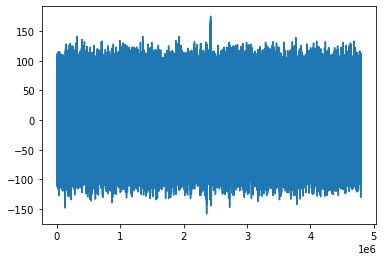

In [26]:
plt.plot(R.recordings[0].analog_streams[0].channel_data[0, :])

In [ ]:
vs=R.recordings[0].analog_streams[0].channel_data[:, :]

In [ ]:
WellID=np.load(MetadataMaskPath+'/'+'WellID.csv.npy')
Welllabel=np.load(MetadataMaskPath+'/'+'WellLabel.csv.npy')
Channellabel=np.load(MetadataMaskPath+'/'+'ChannelLabel.csv.npy')
ChannelID=list(R.recordings[0].analog_streams[0].channel_infos.keys())

In [ ]:
last=ChannelID[29]

In [ ]:
v=vs[29, :]

In [ ]:
lof=[]

In [ ]:
chxor2=AP_detection_lofnew(data_path, lof, v, 0.5, 5, True, True, 20000, 3, False, start=0)

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(chxor2[2], bins=100, alpha=0.5)
plt.xlabel('ADCvalues')
plt.ylabel('Count')
plt.title('Amplitude histogram (median-peak)')



In [4]:
def test_main(Recordingfilename, MetadataFilename, MetadataMaskPath):


    """Function to detect spike and write spike detections in a table for a single recording file"""

    D={'Timestamp [µs]':[], 'Peak Amplitudes':[], 'Duration':[], 'Channel ID':[], 'Well ID':[], 'Well Label':[],
       'Channel Label':[], 'Experiment':[], 'Dose Label':[], 'Compound ID':[], 'ES_condition':[]}
    recording=McsPy.McsData.RawData(Recordingfilename)
    #print(recording.recordings[0].event_streams.keys())

    tree = etree.parse(MetadataFilename)
    lab=lab_book(tree)
    WellID=np.load(MetadataMaskPath+'/'+'WellID.csv.npy')
    Welllabel=np.load(MetadataMaskPath+'/'+'WellLabel.csv.npy')
    Channellabel=np.load(MetadataMaskPath+'/'+'ChannelLabel.csv.npy')
    ExperimentID=tree.xpath('//ExperimentID/text()')[0]


    ChannelID=list(recording.recordings[0].analog_streams[0].channel_infos.keys())
    #print(list(recording.recordings[0].analog_streams[0].channel_infos.keys()))

    ChannelID=[int(i) for i in ChannelID]





    for i in ChannelID:


            index=int(recording.recordings[0].analog_streams[0].channel_infos[i].row_index)




    Compounds=tree.xpath('//CompoundID/text()')
    #print(Compounds)
    Compound=recording.comment

    Labels=Dilutions(tree, Compound)
    starts=recording.recordings[0].analog_streams[1].timestamp_index[:, 1].astype('int64')
    stops=recording.recordings[0].analog_streams[1].timestamp_index[:, 2].astype('int64')
    esim=recording.recordings[0].analog_streams[1].timestamp_index[:, 0].astype('int64')

    #print(starts, stops, esim, 'start, stops, esim')



    for j in range(len(starts)):

        dose_label=Labels[j]
        dose_start=int(starts[j])
        dose_stop=int(stops[j])
        #print(dose_start, dose_stop, dose_label)

    ES_Electrodes=tree.xpath('//ChannelID/text()')
    info=led_info(Recordingfilename, MetadataFilename)


    return lab